## Differential Time Lapse tool Scratchpad

1. getting familiar with the FITS file format and handling it in Python using astropy pyfits
2. analyzing ways to align images:
      1. Feature extraction and alignment
      2. Using 3-point asterisms. Source: https://github.com/toros-astro/astroalign
      3. Using WCS data in headers.
3. compiling aligned images into a video stream      

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
import numpy as np
plt.style.use(astropy_mpl_style)


In [2]:
%matplotlib inline
import time

In [10]:
path = r'20190405T110036.fits.fz'
path1 = r'20190405T110332.fits.fz'
path2 = r'20190405T110633.fits.fz'



If the .data attribute on the primary HDU is None that means the primary HDU contains no data. You can confirm this by checking the file info:<br>

hdulist.info() <br>
Chances are you're trying to read a multi-extension FITS file, and the data you're looking for is in another castle, I mean, HDU.  disable_image_compression=True wouldn't help since that disables support for compressed images :)<br>

ETA: In fact, a tile-compressed FITS image can never be in the primary HDU, since it's stored internally as a binary table, which can only be an extension HDU.<br>

Source: [stackoverflow ](https://stackoverflow.com/questions/20844385/pyfits-read-compressed-fits-file)

In [4]:
hdul = fits.open(path)
hdul.info()
hdu1 = hdul[1]
print("BZERO:{0} and BSCALE: {1} with BITPIX: {2}".format(hdu1.header['bzero'],hdu1.header['bscale'],hdu1.header['bitpix']))

data_grab = hdul[0].data
print(type(data_grab),data_grab)
image_data1 = hdul[1].data
print(type(image_data1))
print('Note: Headers BZERO,BSCALE are lost after scaling')
print(hdul[1].header)
hdul.close()

Filename: 20190405T110036.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU    180   (5208, 3476)   int16   
BZERO:32768 and BSCALE: 1 with BITPIX: 16
<class 'NoneType'> None
<class 'numpy.ndarray'>
Note: Headers BZERO,BSCALE are lost after scaling
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                   16 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 5208 / width of table in bytes                        NAXIS2  =                 3476 / number of rows in table                        PCOUNT  =                    0 / size of special data area                      GCOUNT  =                    1 / one data group (required keyword)              XTENSION= 'BINTABLE'           / binary table extension                         

In [5]:
hdul = fits.open(path1)
hdul.info()
hdu1 = hdul[1]
print("BZERO:{0} and BSCALE: {1} with BITPIX: {2}".format(hdu1.header['bzero'],hdu1.header['bscale'],hdu1.header['bitpix']))

data_grab = hdul[0].data
print(type(data_grab),data_grab)
image_data2 = hdul[1].data
print(type(image_data1))
print('Note: Headers BZERO,BSCALE are lost after scaling')
print(hdul[1].header['CTYPE1'])
print(hdul[1].header['CTYPE2'])
hdul.close()

Filename: 20190405T110332.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU    180   (5208, 3476)   int16   
BZERO:32768 and BSCALE: 1 with BITPIX: 16
<class 'NoneType'> None
<class 'numpy.ndarray'>
Note: Headers BZERO,BSCALE are lost after scaling
RA---TAN-SIP
DEC--TAN-SIP


As expected, the PrimaryHDU is empty. The image is in the extensions i.e here in the second HDU.

This is a numpy ndarray which can be plotted with matplotlib

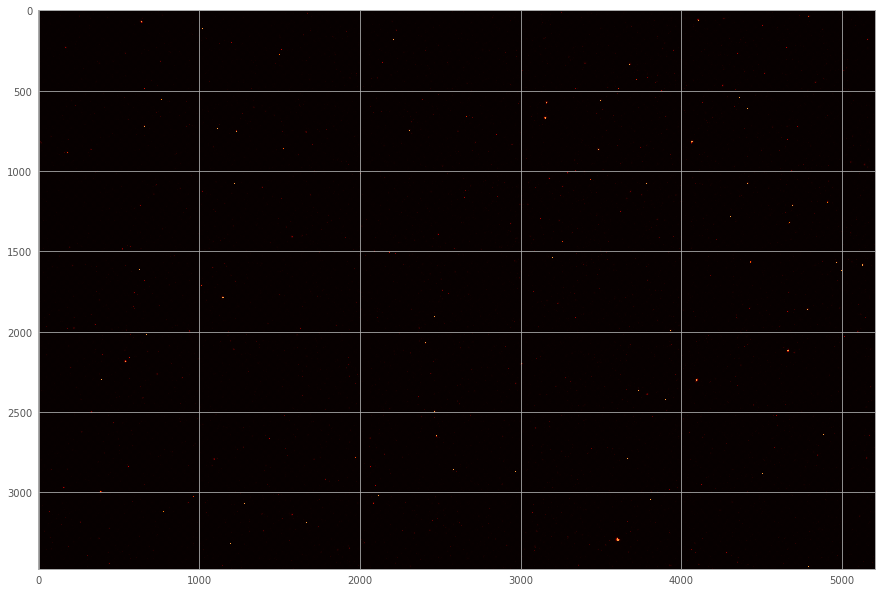

In [6]:
plt.rcParams['figure.figsize'] = [15,15]
plt.imshow(image_data1)

Sometimes an image is scaled, i.e. the data stored in the file is not the image’s physical (true) values, but linearly transformed according to the equation:

physical value = BSCALE * (storage value) + BZERO <br>

BSCALE and BZERO are stored as keywords of the same names in the header of the same HDU. The most common use of scaled image is to store unsigned 16-bit integer data because FITS standard does not allow it. In this case, the stored data is signed 16-bit integer (BITPIX=16) with BZERO=32768 (2^15), BSCALE=1.

In astropy.io.fits, fits.open scales by default unless you specify "do_not_scale_image_data = True"

Once the data is accessed with scaling ON, the headers BZERO and BSCALE are removed

### Attempt to align images using scikit image feature extractor { infeasible }

In [7]:
from skimage.feature import (match_descriptors, corner_harris,corner_peaks, ORB, plot_matches)
from skimage import transform as tf

In [8]:
descriptor_extractor = ORB(n_keypoints=10) 


In [9]:
time_start_x = time.time()
descriptor_extractor.detect_and_extract(image_data1)
descriptors_1 = descriptor_extractor.descriptors
keypoints_1 = descriptor_extractor.keypoints

descriptor_extractor.detect_and_extract(image_data2)
descriptors_2 = descriptor_extractor.descriptors
keypoints_2 = descriptor_extractor.keypoints
time_end_x = time.time()

print("Time taken is {0}".format(time_end_x-time_start_x))

Time taken is 128.7661533355713


In [10]:
matches12 = match_descriptors(descriptors_1, descriptors_2, cross_check=True)

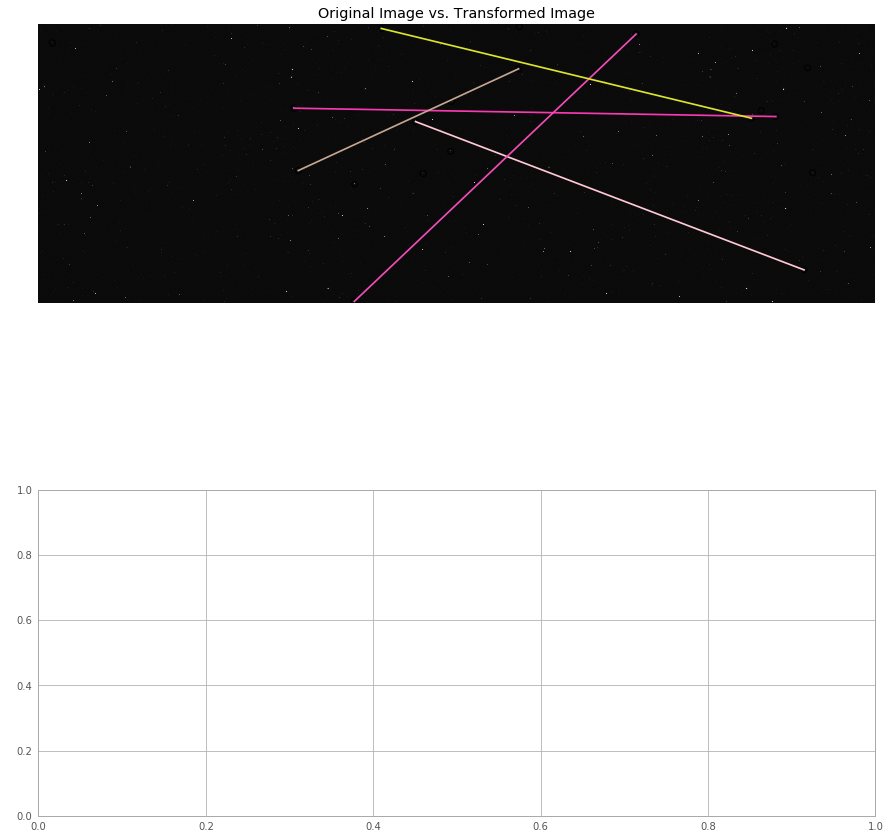

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=1)
plt.gray()
plt.rcParams['figure.figsize'] = [30,30]
plot_matches(ax[0], image_data1, image_data2, keypoints_1, keypoints_2, matches12)
ax[0].axis('off')
ax[0].set_title("Original Image vs. Transformed Image")

plt.show()

It seems running ORB detection on stellar images is a bad idea. Because of the absence of unique features the algorithm takes too long to run on a pair of images in itself and makes a lot of errors. This idea is deemed infeasible at the moment.The next idea is to use a package called astroalign which uses 3-point asterism matching.

TIme taken: <b>128.3 seconds</b> for only 10 keypoints

### Using Astroalign package.

In [12]:
import astroalign

In [13]:
time_start_astroalign = time.time()
img_aligned = astroalign.register(image_data1,image_data2)
time_end_astroalign = time.time()
print("Time taken using astroalign is {0}".format(time_end_astroalign - time_start_astroalign))

Time taken using astroalign is 106.82760500907898


In [14]:
p, (pos_img, pos_img_rot) = astroalign.find_transform(image_data1, image_data2)

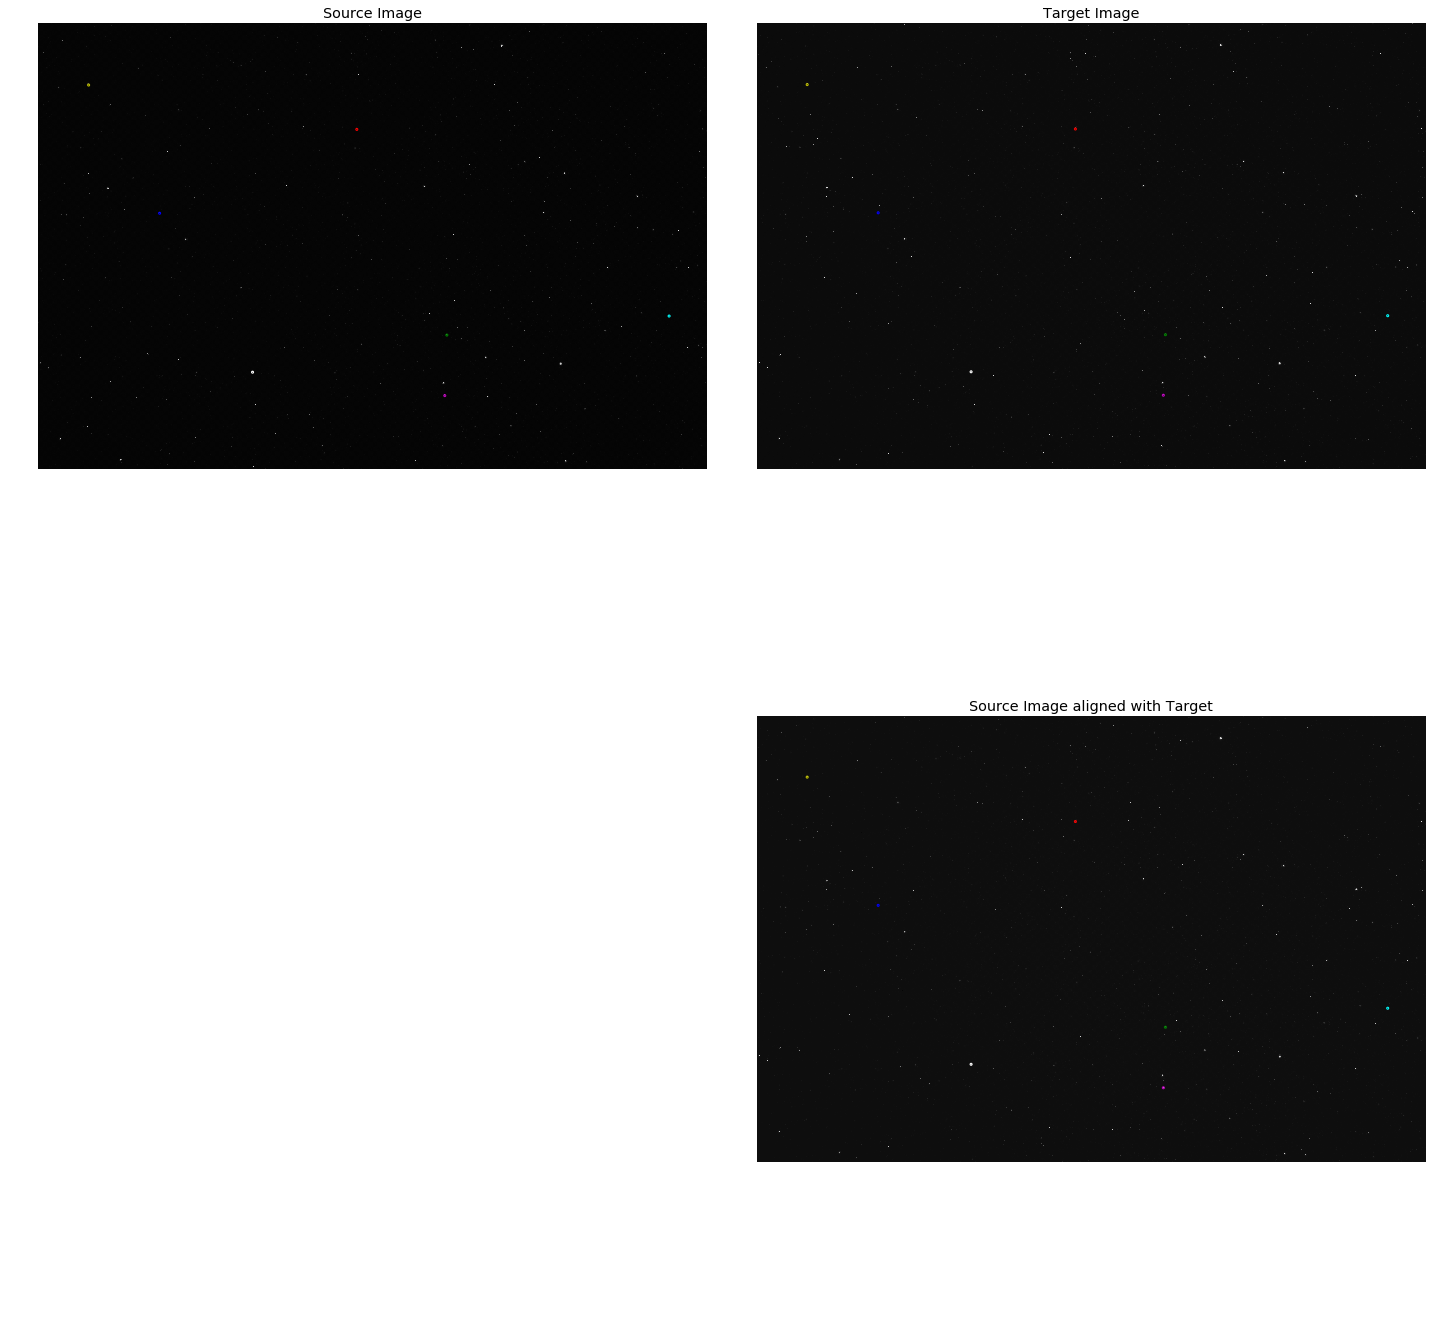

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

colors = ['r', 'g', 'b', 'y', 'cyan', 'w', 'm']

axes[0, 0].imshow(image_data1, cmap='gray', interpolation='none', origin='lower')
axes[0, 0].axis('off')
axes[0, 0].set_title("Source Image")
for (xp, yp), c in zip(pos_img[:len(colors)], colors):
    circ = plt.Circle((xp, yp), 4, fill=False, edgecolor=c, linewidth=2)
    axes[0, 0].add_patch(circ)

axes[0, 1].imshow(image_data2, cmap='gray', interpolation='none', origin='lower')
axes[0, 1].axis('off')
axes[0, 1].set_title("Target Image")
for (xp, yp), c in zip(pos_img_rot[:len(colors)], colors):
    circ = plt.Circle((xp, yp), 4 * p.scale, fill=False, edgecolor=c, linewidth=2)
    axes[0, 1].add_patch(circ)

axes[1, 1].imshow(img_aligned, cmap='gray', interpolation='none', origin='lower')
axes[1, 1].axis('off')
axes[1, 1].set_title("Source Image aligned with Target")
for (xp, yp), c in zip(pos_img_rot[:len(colors)], colors):
    circ = plt.Circle((xp, yp), 4 * p.scale, fill=False, edgecolor=c, linewidth=2)
    axes[1, 1].add_patch(circ)

axes[1, 0].axis('off')

plt.tight_layout()
plt.show()

The aligning seems to have worked but the time taken to align two sequential images is high.
Time taken is <b>108.1 seconds </b><br>
So moving on to alignment using Header information.

### Image Alignment using WCS Header Information

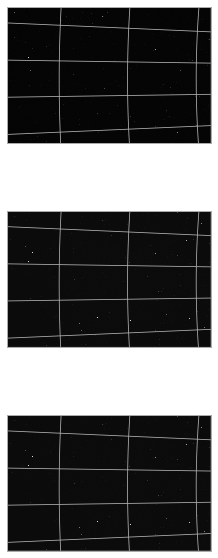

In [13]:
from astropy.wcs import WCS
plt.rcParams['figure.figsize'] = [10,10]
# Opening first image in 'path'
hdul = fits.open(path)
image_hdu = hdul[1]
wcs = WCS(image_hdu.header)
fig = plt.figure()
fig.add_subplot(311, projection=wcs)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.imshow(image_hdu.data,cmap='gray')
hdul.close()

#opening second image in 'path1'
hdul1 = fits.open(path1)
image_hdu1 = hdul1[1]
wcs1 = WCS(image_hdu1.header)
fig.add_subplot(312, projection=wcs1)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.imshow(image_hdu1.data,cmap='gray')
hdul1.close()

#opening third image in 'path2'
hdul2 = fits.open(path2)
image_hdu2 = hdul2[1]
wcs2 = WCS(image_hdu2.header)
fig.add_subplot(313, projection=wcs2)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.imshow(image_hdu1.data,cmap='gray')
hdul2.close() 

I'll now try to identify the pixel corresponding to image_2 with the wcs coordinates of reference pixel in image_1 

In [25]:
wcs_method_start = time.time()


wcs1 = WCS(image_hdu1.header)

wcs.printwcs()
wcs1.printwcs()
wcs2
pixel_values_image_1 = [[2604.5,1738.5],[2604,1738],[2600,1730],[2605,1740]]
reference_pixel_wcs_values = wcs.all_pix2world(pixel_values_image_1,1)
pixel_values_image_2 = wcs1.all_world2pix(reference_pixel_wcs_values,1)
print(pixel_values_image_2)

for ii in range(len(pixel_values_image_1)):
    x_shift,y_shift = pixel_values_image_2[ii]-pixel_values_image_1[ii]
    print("\nx shift is {0} pixels and y shift is {1} pixels".format(x_shift,y_shift))

wcs_method_end = time.time()

print("\nTime taken is {0}".format(wcs_method_end-wcs_method_start))
print(wcs.det2im(pixel_values_image_2,1))

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 217.188642184  -33.6425673333  
CRPIX : 2604.5  1738.5  
CD1_1 CD1_2  : -9.20976618818e-06  -0.00286084536381  
CD2_1 CD2_2  : -0.00286227842257  1.05400925039e-05  
NAXIS : 5208  3476
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 217.199353665  -33.6427982859  
CRPIX : 2604.5  1738.5  
CD1_1 CD1_2  : -9.23409217247e-06  -0.00286066404264  
CD2_1 CD2_2  : -0.00286209749112  1.0526596121e-05  
NAXIS : 5208  3476
[[2604.43093992 1741.61747737]
 [2603.93085689 1741.11750059]
 [2599.92978082 1733.11742669]
 [2604.93112597 1743.11751846]]

x shift is -0.06906008065834612 pixels and y shift is 3.117477370702545 pixels

x shift is -0.06914311006084972 pixels and y shift is 3.1175005897762276 pixels

x shift is -0.07021917960992141 pixels and y shift is 3.1174266885186626 pixels

x shift is -0.06887403351583998 pixels and y shift is 3.1175184556773274 pixels

Time taken i

The shift in pixels is identified and using multiple points, we can safely find an affine transform between the two images and align them correspondingly. Once aligned, it becomes possible to easily find the differences and build a timelapse from them.

#### Summary of Alignment Methods
| Method    | Time taken (seconds) | Accuracy |
|-----------|-----|---|
| ORB feature matching   | 128 | Poor |
| Astroalign package   | 106 | Good |
| WCS to pixel coordinates | <b>0.108</b> | Best |


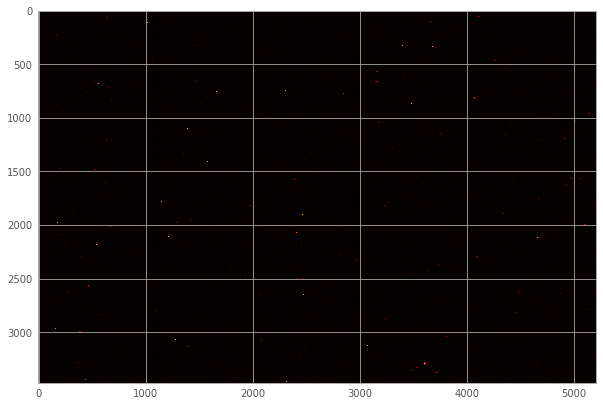

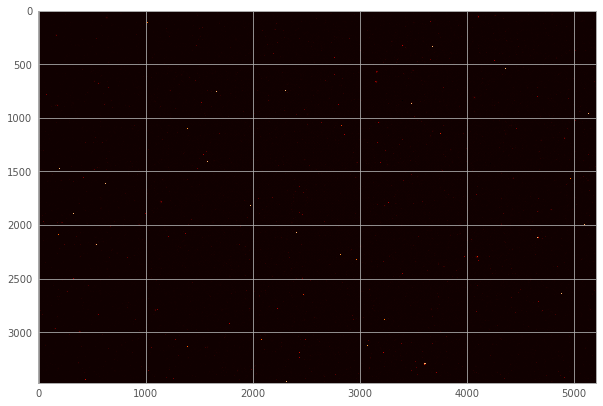

In [51]:
plt.imshow(image_hdu.data[:3473,:])
plt.figure()
plt.imshow(image_hdu1.data[3:,:])

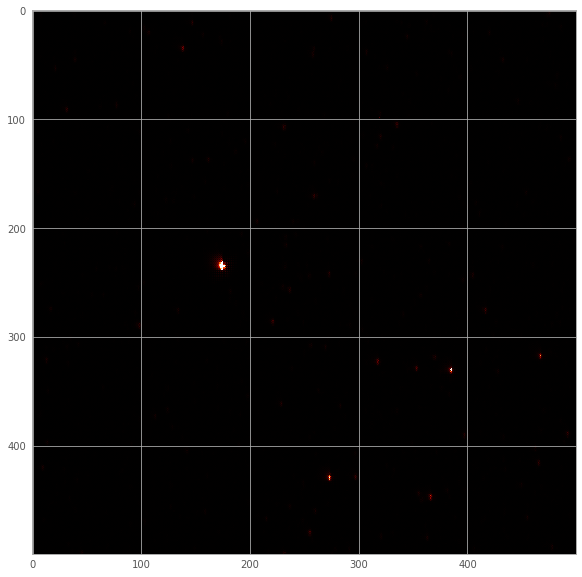

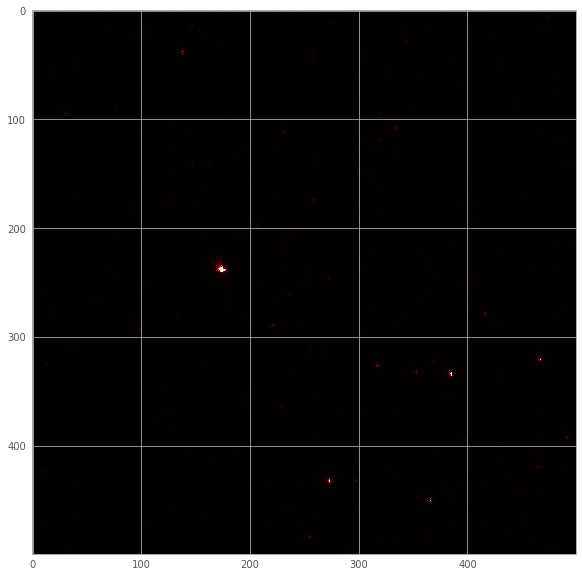

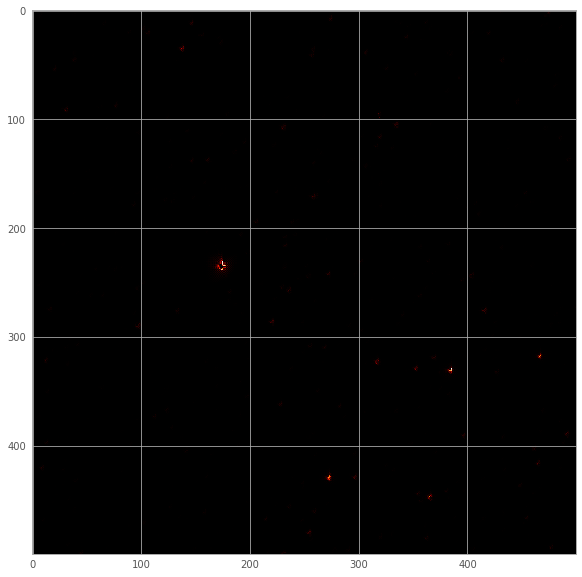

In [72]:
plt.imshow(image_hdu.data[:500,:500])
plt.figure()
plt.imshow(image_hdu1.data[:500,:500])
plt.figure()
plt.imshow(abs(image_hdu.data[:500,:500].astype(np.int16)-image_hdu1.data[3:503,1:501].astype(np.int16)))
#refer = image_hdu.data[:500,:500]-image_hdu1.data[4:504,:500]


In [25]:
x = np.array([65532,0],dtype=np.uint16)
y = np.array([65536,2],dtype=np.uint16)
print(x-y)
print(hdul[1].header['RA-MNT'])
print(hdul[1].header['HA-MNT'])
print(hdul[1].header['DEC-MNT'])
print(hdul1[1].header['RA-MNT'])
print(hdul1[1].header['HA-MNT'])
print(hdul1[1].header['DEC-MNT'])
print(hdul2[1].header['RA-MNT'])
print(hdul2[1].header['HA-MNT'])
print(hdul2[1].header['DEC-MNT'])

[65532 65534]
217.3031
23.04837039793174
-33.7306
217.3031
23.09738955374964
-33.7306
217.3031
23.14766961641603
-33.7306


In [29]:
hdul[1].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5208 / width of table in bytes                        
NAXIS2  =                 3476 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
XTENSION= 'BINTABLE'           / binary table extension                         
FILTER  = 'RGGB    '                                                            
ISO     =                  100                                                  
EXPTIME =                  120                                                  
CAMTEMP = '17 C    '           / Celsius - From CR2                             
CIRCCONF= '0.019 mm'        